In [1]:
pip install textblob keras-tuner scikit-learn tensorflow requests feedparser requests_cache requests_ratelimiter pyrate_limiter 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from textblob import TextBlob  # for sentiment analysis
from kerastuner.tuners import RandomSearch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

import requests
import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import feedparser
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter

C:\Users\Brendan\AppData\Local\Temp\ipykernel_335816\4281950304.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [3]:
headers = {
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0'
}

class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass

session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5)),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket,
    backend=SQLiteCache("yfinance.cache"),
)

In [4]:
def scrape_google_news(keyword, current_date):
    headlines = []
    
    # Format start and end dates in the required format (YYYY-MM-DD)
#     start_date = start_date.strftime('%Y-%m-%d')
#     end_date = end_date.strftime('%Y-%m-%d')
    
    # Create the Google News URL with the provided keyword and date range
    url = f"https://www.google.com/search?q={keyword}&tbm=nws&source=lnt&tbs=cdr%3A1%2Ccd_min%3A{current_date}%2Ccd_max%3A{current_date}&tbm=nws"
    
    # Send a GET request to the URL
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find all headline elements
    headline_elements = soup.find_all('div', class_='BNeawe vvjwJb AP7Wnd')
    
    # Extract headlines from the elements
    for element in headline_elements:
        headlines.append(element.get_text())
    
    return headlines

def scrape_yahoo_rss(ticker, date):
    date_str = date.strftime('%Y-%m-%d')
    
    start_date = '2023-08-01'
    end_date = '2023-08-30'
    rssfeedurl = f'https://feeds.finance.yahoo.com/rss/2.0/headline?s={ticker}&region=US&lang=en-US&startdate={date_str}&enddate={date_str}'
    # Fetch and parse the RSS feed
    feed = feedparser.parse(rssfeedurl)
    headlines = []
    summaries = []

    for entry in feed.entries:
        headlines.append(entry.title)
        summaries.append(entry.summary)

    return headlines, summaries
    

In [5]:
def calculate_sentiment_score(headlines, summaries):
    """
    Calculate sentiment analysis scores for a list of news headlines and summaries.
    Returns a list of sentiment scores.
    """
    sentiment_scores = []

    for headline, summary in zip(headlines, summaries):
        # Calculate sentiment for both headline and summary
        blob_headline = TextBlob(headline)
        blob_summary = TextBlob(summary)

        # Combine sentiment scores with higher weight on summary
        sentiment_score = (blob_headline.sentiment.polarity + 2 * blob_summary.sentiment.polarity) / 3
        sentiment_scores.append(sentiment_score)
    
    return np.mean(sentiment_scores)

def get_sentiment(ticker, data):
    sentiment_scores = []
    for date in data.index:
        print(".")
        headlines, summaries = scrape_yahoo_rss(ticker, date)
        sentiment_score = calculate_sentiment_score(headlines, summaries)
        sentiment_scores.append(sentiment_score)

    # Create a new column 'Sentiment' in the DataFrame
    return sentiment_scores

def calculate_super_trend(data, period=7, multiplier=3):
    df = data.copy()

    # Calculate True Range (TR)
    df['H-L'] = df['High'] - df['Low']
    df['H-Cp'] = np.abs(df['High'] - df['Close'].shift(1))
    df['L-Cp'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-Cp', 'L-Cp']].max(axis=1)
    del df['H-L'], df['H-Cp'], df['L-Cp']

    # Calculate ATR (Average True Range)
    df['ATR'] = df['TR'].rolling(window=period).mean()

    # Calculate Super Trend Upper Band (STUB) and Lower Band (STLB)
    df['STUB'] = df['High'] + multiplier * df['ATR']
    df['STLB'] = df['Low'] - multiplier * df['ATR']

    # Calculate Super Trend
    df['SuperTrend'] = df['STUB']
    df.loc[df['Close'] < df['STUB'], 'SuperTrend'] = df['STLB']

    return df['SuperTrend']

def ADX(data: pd.DataFrame, period: int):
    """
    Computes the ADX indicator.
    """
    
    df = data.copy()
    alpha = 1/period

    # TR
    df['H-L'] = df['High'] - df['Low']
    df['H-C'] = np.abs(df['High'] - df['Close'].shift(1))
    df['L-C'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-C', 'L-C']].max(axis=1)
    df.drop(['H-L', 'H-C', 'L-C'], axis=1, inplace=True)

    # ATR
    df['ATR'] = df['TR'].ewm(alpha=alpha, adjust=False).mean()

    # +-DX
    df['H-pH'] = df['High'] - df['High'].shift(1)
    df['pL-L'] = df['Low'].shift(1) - df['Low']
    df['+DX'] = np.where(
        (df['H-pH'] > df['pL-L']) & (df['H-pH'] > 0),
        df['H-pH'],
        0.0
    )
    df['-DX'] = np.where(
        (df['H-pH'] < df['pL-L']) & (df['pL-L'] > 0),
        df['pL-L'],
        0.0
    )
    df.drop(['H-pH', 'pL-L'], axis=1, inplace=True)

    # +- DMI
    df['S+DM'] = df['+DX'].ewm(alpha=alpha, adjust=False).mean()
    df['S-DM'] = df['-DX'].ewm(alpha=alpha, adjust=False).mean()
    df['+DMI'] = np.where(df['ATR'] != 0, (df['S+DM'] / df['ATR']) * 100, 0.0)
    df['-DMI'] = np.where(df['ATR'] != 0, (df['S-DM'] / df['ATR']) * 100, 0.0)
    df.drop(['S+DM', 'S-DM'], axis=1, inplace=True)

    # ADX
    df['DX'] = np.where(
        (df['+DMI'] + df['-DMI']) != 0,
        (np.abs(df['+DMI'] - df['-DMI']) / (df['+DMI'] + df['-DMI'])) * 100,
        0.0
    )
    return df['DX'].ewm(alpha=alpha, adjust=False).mean()


# Calculate DEMA indicators
def calculate_dema(data, window):
    ema = data['Close'].ewm(span=window, adjust=False).mean()
    dema = 2 * ema - ema.ewm(span=window, adjust=False).mean()
    return dema

def calculate_technical_indicators(symbol, data):
    print(data)
    # Calculate moving averages
    data['SMA10'] = data['Close'].rolling(window=10).mean()
    data['SMA30'] = data['Close'].rolling(window=30).mean()
    data['SMA90'] = data['Close'].rolling(window=90).mean()
    # Exponential Moving Average
#     data['EMA10'] = data['Close'].ewm(span=10, adjust=False).mean()
#     data['EMA30'] = data['Close'].ewm(span=30, adjust=False).mean()
#     data['EMA30'] = data['Close'].ewm(span=30, adjust=False).mean()
    # Rate of Change (ROC)
    data['ROC'] = data['Close'].pct_change(periods=10)

    # Stochastic Oscillator
#     low_min  = data['Low'].rolling(window=14).min()
#     high_max = data['High'].rolling(window=14).max()
#     data['%K'] = (data['Close'] - low_min)/(high_max - low_min) * 100
#     data['%D'] = data['%K'].rolling(window=3).mean()
#     data['DEMA10'] = calculate_dema(data, window=10)
#     data['DEMA30'] = calculate_dema(data, window=30)
#     data['DEMA90'] = calculate_dema(data, window=90)
    # Calculate relative strength index (RSI)
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # Calculate Bollinger Bands
    window = 20
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
#     data['Upper_BB'] = rolling_mean + (2 * rolling_std)
#     data['Lower_BB'] = rolling_mean - (2 * rolling_std)
    data['Volatility'] = data['Close'].pct_change().rolling(window=20).std() * 100
    # Additional indicators
    data['MACD'] = data['Close'].ewm(span=12).mean() - data['Close'].ewm(span=26).mean()
    # MACD Histogram
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    data['MACD_Histogram'] = data['MACD'] - data['MACD_Signal']
#     data['Signal_Line'] = data['MACD'].ewm(span=9).mean
    data['ATR'] = data['High'] - data['Low']
    data['SuperTrend'] = calculate_super_trend(data)
#     print("getting sentiment...")
#     data['Sentiment'] = get_sentiment(symbol, data)
#     data['ADX'] = ADX(data, period=14) # Calculate ADX using the ADX function
       
    return data

def fetch_historical_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date, session=session)
    return data

def implement_trading_logic(predictions, threshold=0.66):
    # Implement your trading logic here
    # For example, buy when prediction > threshold, sell when prediction <= threshold
    trading_actions = [1 if prediction > threshold else 0 for prediction in predictions]
    return trading_actions

In [6]:
# Fetch historical data for training
symbol = 'SPY'
start_date_train = datetime.date(2010, 1, 1)
end_date_train = datetime.date(2022, 1, 1)
data_train = calculate_technical_indicators(symbol, fetch_historical_data(symbol, start_date_train, end_date_train)).dropna()
data_train

[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-01-04  112.370003  113.389999  111.510002  113.330002   87.791794   
2010-01-05  113.260002  113.680000  112.849998  113.629997   88.024162   
2010-01-06  113.519997  113.989998  113.430000  113.709999   88.086159   
2010-01-07  113.500000  114.330002  113.180000  114.190002   88.457985   
2010-01-08  113.889999  114.620003  113.660004  114.570000   88.752342   
...                ...         ...         ...         ...         ...   
2021-12-27  472.059998  477.309998  472.010010  477.260010  466.123810   
2021-12-28  477.720001  478.809998  476.059998  476.869995  465.742950   
2021-12-29  476.980011  478.559998  475.920013  477.480011  466.338654   
2021-12-30  477.929993  479.000000  475.670013  476.160004  465.049500   
2021-12-31  475.640015  476.859985  474.670

,Open,High,Low,Close,Adj Close,Volume,SMA10,SMA30,SMA90,ROC,RSI,Volatility,MACD,MACD_Signal,MACD_Histogram,ATR,SuperTrend
Date,,,,,,,,,,,,,,,,,
2010-05-12,116.290001,117.620003,116.089996,117.449997,91.358040,235607100,116.800000,118.736000,114.560222,-0.016167,43.142526,1.725795,-0.694480,-0.167449,-0.527031,1.530006,102.697142
2010-05-13,117.129997,117.680000,115.889999,115.989998,90.222397,234452500,116.313000,118.702333,114.589778,-0.040295,39.101120,1.742076,-0.716861,-0.277332,-0.439529,1.790001,103.200002
2010-05-14,115.120003,115.330002,112.870003,113.889999,88.588890,345601400,115.821000,118.572000,114.592667,-0.041411,36.838387,1.751897,-0.893615,-0.400588,-0.493027,2.459999,99.627151
2010-05-17,114.199997,114.519997,111.769997,113.949997,88.635574,325739800,115.181000,118.411666,114.595333,-0.053178,41.128069,1.747578,-1.017129,-0.523897,-0.493233,2.750000,102.491431
2010-05-18,114.879997,115.220001,112.029999,112.400002,87.429893,360556800,114.669000,118.190333,114.575444,-0.043567,36.669218,1.743588,-1.225870,-0.664291,-0.561579,3.190002,103.252858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,472.059998,477.309998,472.010010,477.260010,466.123810,56808600,466.044003,465.017002,453.531445,0.013851,63.041950,1.257343,2.159430,1.379720,0.779710,5.299988,450.641445
2021-12-28,477.720001,478.809998,476.059998,476.869995,465.742950,47274600,467.074002,465.337003,453.942668,0.022076,56.959972,1.235124,2.803125,1.664401,1.138725,2.750000,456.971436
2021-12-29,476.980011,478.559998,475.920013,477.480011,466.338654,54503000,468.486005,465.672003,454.321779,0.030473,56.516061,1.133916,3.324163,1.996353,1.327810,2.639984,459.295750


In [7]:
feature_names = ['Volume', 'SMA10', 'SMA30', 'SMA90', 'ROC',  'RSI', 'Volatility', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'ATR', 'SuperTrend']    
print(len(feature_names))
from sklearn.pipeline import Pipeline
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
def align_and_standardize(data_in,feature_names,shift=-1):
    scaler = StandardScaler()
    data = data_in.copy()
    # Shift the indicators to align with future prices to predict
    for feature in feature_names:
        data[feature] = data[feature].shift(shift)
    data.dropna(inplace=True)

    # Standardize the columns
    data[feature_names] = scaler.fit_transform(data[feature_names])
    return data.drop(['Close', 'Adj Close', 'Open', 'High', 'Low'], axis=1).values

# Clearing the TensorFlow session
K.clear_session()
# First align and standardize
features_train = align_and_standardize(data_train, feature_names)
# Create labels
labels_train = np.where(data_train['Close'].shift(-1) > data_train['Close'], 1, 0)
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(features_train[:-1], labels_train[:-1], test_size=0.1, random_state=42)

# Preprocessing pipeline
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

preprocess = Pipeline([
    ('scaler', scaler),
    ('imputer', imputer)
])

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(features_train, labels_train, test_size=0.1, random_state=42)

# Apply preprocessing
X_train_preprocessed = preprocess.fit_transform(X_train)
X_val_preprocessed = preprocess.transform(X_val)
X_train_preprocessed

12


array([[-0.44621298,  0.30630826,  0.29201816, ..., -0.09896318,
        -0.0756515 ,  0.36009564],
       [-0.54788998, -0.04347242, -0.04569581, ..., -0.36682797,
        -0.6037083 ,  0.00347451],
       [ 0.65679603, -1.37046122, -1.3599945 , ..., -0.63756622,
        -0.4216231 , -1.3845044 ],
       ...,
       [-0.14152167, -0.33413998, -0.37833656, ...,  1.43714243,
        -0.36699893, -0.28608408],
       [ 0.01256708, -0.2334003 , -0.20521666, ..., -0.54094487,
        -0.13938896, -0.24996061],
       [-0.17052371, -0.69583686, -0.68479313, ..., -0.15691228,
        -0.39886071, -0.67892942]])

In [8]:
model = Sequential()

# Input Layer
model.add(Dense(128, activation='relu', input_shape=(X_train_preprocessed.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Hidden Layer 1
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))  # units and l2 from tuner
model.add(BatchNormalization())
model.add(Dropout(0.3))  # dropout from tuner

# Hidden Layer 2
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.0001)))  # units and l2 from tuner
model.add(BatchNormalization())
model.add(Dropout(0.4))  # dropout from tuner

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# model_checkpoint = ModelCheckpoint("best_model", save_best_only=True)

tqdm_callback = TqdmCallback(verbose=0)  # progress bar

# Train the model
model.fit(X_train_preprocessed, y_train,
          epochs=30,
          batch_size=64,
          validation_data=(X_val_preprocessed, y_val),
          verbose=0,  # silent mode
          callbacks=[tqdm_callback])

0epoch [00:00, ?epoch/s]

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Get predictions
predictions = model.predict(X_val_preprocessed)
binary_predictions = [1 if x > 0.5 else 0 for x in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_val, binary_predictions)
print(f"Prediction Accuracy: {accuracy * 100:.2f}%")

10/10 [==============================] - 0s 710us/step
Prediction Accuracy: 70.41%


In [10]:
def permutation_importance(model, X_val, y_val, metric=accuracy_score, n_repeats=30):
    baseline_score = metric(y_val, (model.predict(X_val) > 0.5).astype("int32"))
    feature_importances = np.zeros((n_repeats, X_val.shape[1]))
    
    for i in range(n_repeats):
        for col in range(X_val.shape[1]):
            random_col = np.random.permutation(X_val[:, col])
            new_X_val = X_val.copy()
            new_X_val[:, col] = random_col
            new_y_pred = (model.predict(new_X_val) > 0.5).astype("int32")
            new_score = metric(y_val, new_y_pred)
            feature_importances[i, col] = baseline_score - new_score
            
    mean_importances = np.mean(feature_importances, axis=0)
    return mean_importances

# Running it multiple times and averaging might give you more stable results
importances = permutation_importance(model, X_val_preprocessed, y_val)
print(f"Feature importances: {importances}")
# Your actual feature names in the order they appear in your data
# feature_names = ['Open', 'High', 'Low', 'Volume', 'SMA30', 'SMA200', 'RSI', 'Upper_BB', 'Lower_BB', 'Volatility', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'ROC', 'EMA50']

# Create a dictionary with feature names and their importances
feature_importance_dict = dict(zip(feature_names, importances))

# Sort the dictionary by importance value
sorted_importances = {k: v for k, v in sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)}

print("Feature importances:")
for feature, importance in sorted_importances.items():
    print(f"{feature}: {importance}")
print("Length of importances: ", len(importances))
print("Length of feature_names: ", len(feature_names))
print(f"Feature importances: {importances}")
# Your actual feature names in the order they appear in your data
# feature_names = ['Open', 'High', 'Low', 'Volume', 'SMA30', 'SMA200', 'RSI', 'Upper_BB', 'Lower_BB', 'Volatility', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'ROC', 'EMA50']

# Create a dictionary with feature names and their importances
feature_importance_dict = dict(zip(feature_names, importances))

# Sort the dictionary by importance value
sorted_importances = {k: v for k, v in sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)}

print("Feature importances:")
for feature, importance in sorted_importances.items():
    print(f"{feature}: {importance}")
print("Length of importances: ", len(importances))
print("Length of feature_names: ", len(feature_names))

10/10 [==============================] - 0s 710us/step


10/10 [==============================] - 0s 602us/step


10/10 [==============================] - 0s 759us/step
Feature importances: [0.05759637 0.00793651 0.02346939 0.02539683 0.17709751 0.12210884
 0.0170068  0.05952381 0.0430839  0.11122449 0.02108844 0.02482993]
Feature importances:
ROC: 0.17709750566893423
RSI: 0.12210884353741497
MACD_Histogram: 0.11122448979591838
MACD: 0.05952380952380952
Volume: 0.057596371882086175
MACD_Signal: 0.043083900226757385
SMA90: 0.025396825396825425
SuperTrend: 0.024829931972789144
SMA30: 0.023469387755102065
ATR: 0.021088435374149683
Volatility: 0.017006802721088454
SMA10: 0.007936507936507945
Length of importances:  12
Length of feature_names:  12
Feature importances: [0.05759637 0.00793651 0.02346939 0.02539683 0.17709751 0.12210884
 0.0170068  0.05952381 0.0430839  0.11122449 0.02108844 0.02482993]
Feature importances:
ROC: 0.17709750566893423
RSI: 0.12210884353741497
MACD_Histogram: 0.11122448979591838
MACD: 0.05952380952380952
Volume: 0.057596371882086175
MACD_Signal: 0.043083900226757385
SMA90: 0.

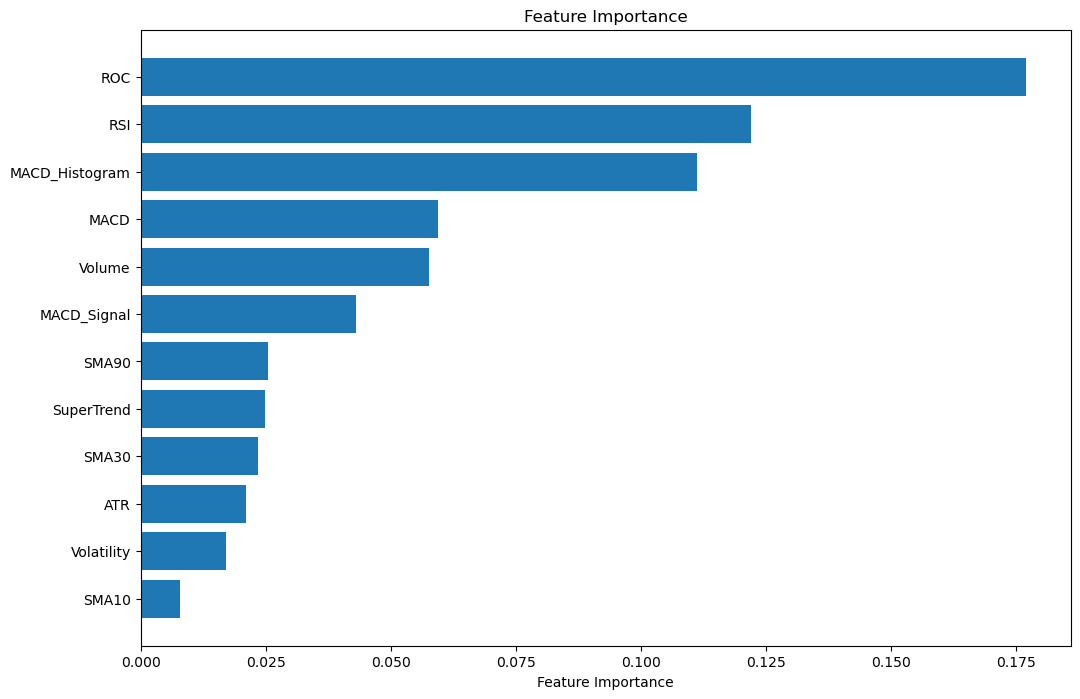

In [11]:
# Convert the importances list to a numpy array
importances = np.array(importances)

# Sort the indices based on importance values
sorted_indices = np.argsort(importances)

# Create the plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_indices)), importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

Final Balance: $137599.34
Maximum Drawdown: 5.19%
CAGR: 31.47%
Sharpe Ratio: -1.30
Sortino Ratio: -1.60


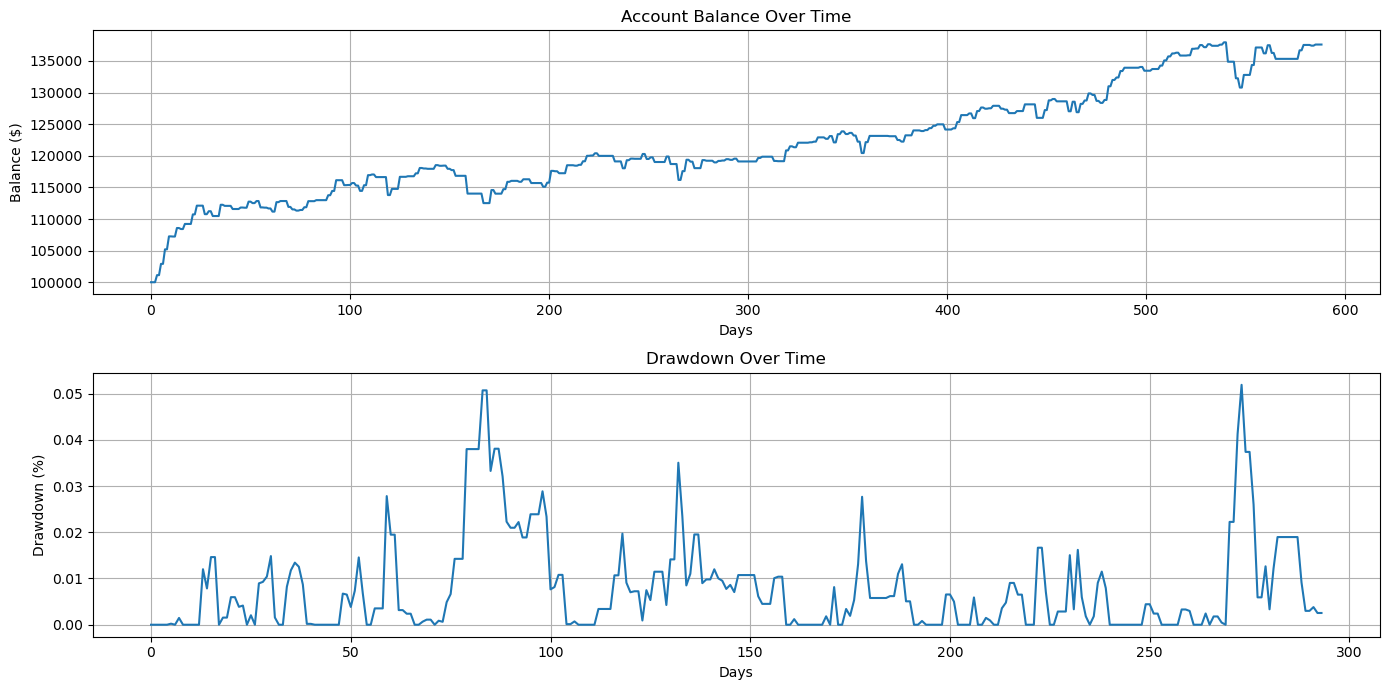

In [12]:
# Initialize variables
initial_balance = 100000  # Your initial capital

peak_balance = initial_balance
balance = initial_balance
stock_quantity = 0
buy_price = 0
max_drawdown = 0.0
drawdown_history = []
# Initialize variables for additional portfolio calculations
total_days = len(binary_predictions)
returns = []
balance_history = [initial_balance]

# Assuming you have a DataFrame or array for the validation close prices called 'val_close_prices'
val_close_prices = data_train['Close'].iloc[-len(y_val):].values

# Buy or sell based on the prediction
for i in range(len(binary_predictions)):
    if binary_predictions[i] == 1:  # Buy signal
        if stock_quantity == 0:
            stock_quantity = balance // val_close_prices[i]
            balance -= stock_quantity * val_close_prices[i]
            buy_price = val_close_prices[i]
    else:  # Sell signal
        if stock_quantity > 0:
            balance += stock_quantity * val_close_prices[i]
            stock_quantity = 0
    # Append the current total balance to history
    total_balance = balance + (stock_quantity * val_close_prices[i])
    balance_history.append(total_balance)

    # Update peak balance
    if total_balance > peak_balance:
        peak_balance = total_balance
    
    # Calculate daily return
    if i > 0:
        daily_return = (total_balance / balance_history[-2]) - 1
        returns.append(daily_return)

    # Calculate drawdown
    drawdown = (peak_balance - total_balance) / peak_balance
    drawdown_history.append(drawdown)
    
    # Update maximum drawdown
    if drawdown > max_drawdown:
        max_drawdown = drawdown
    # Append the current total balance to history
    total_balance = balance + (stock_quantity * val_close_prices[i])
    balance_history.append(total_balance)

# Final balance and CAGR
final_balance = balance + stock_quantity * buy_price
years = total_days / 252  # Assuming 252 trading days in a year
CAGR = ((final_balance / initial_balance) ** (1 / years)) - 1

# Sharpe and Sortino Ratios
average_return = np.mean(returns)
std_dev = np.std(returns)
sharpe_ratio = (average_return - 0.01) / std_dev  # Assuming 1% risk-free rate

# Only consider negative returns for Sortino Ratio
negative_returns = [x for x in returns if x < 0]
downside_std_dev = np.std(negative_returns)
sortino_ratio = (average_return - 0.01) / downside_std_dev

print(f"Final Balance: ${final_balance:.2f}")
print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")
print(f"CAGR: {CAGR * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")


# Plotting the balance and drawdown
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(balance_history)
plt.title("Account Balance Over Time")
plt.xlabel("Days")
plt.ylabel("Balance ($)")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(drawdown_history)
plt.title("Drawdown Over Time")
plt.xlabel("Days")
plt.ylabel("Drawdown (%)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
start_date_test = datetime.date(2023, 1, 1)
end_date_test = datetime.date(2023, 8, 30)
# Initialize account_values with position information
position_and_cash_value = 10000
# Initialize account values
def initialize_account(tickers):
    return {
        'balance': 10000,
        'value': 0,
        'positions': {t: {'total_qty': 0, 'avg_cost': 0, 'purchases': []} for t in tickers},
        'peak_value': 10000,
        'daily_loss': 0,
        'cooldown': {},
        'last_trade_date': None
    }
# Constants
MAX_DAILY_LOSS = 0.05 # 10% of account balance - Stop Loss * 2
COOLDOWN_PERIOD = 3  # 5 days

position_history = []
# Fetch historical data and calculate technical indicators
def fetch_and_prepare_data(ticker, start_date, end_date):
    data = fetch_historical_data(ticker, start_date, end_date)
    data = calculate_technical_indicators(ticker, data)
    return data

def execute_buy(sym, account_info, max_purchase_percentage, close_price, confidence, drawdown, date):
    account_balance = account_info['balance']
    drawdown_limit = 0.2    
    # Dynamic Adjustments
    if drawdown > drawdown_limit:
        max_purchase_percentage = 0.02  # Lower the purchase percentage during high drawdown
        risk_reward_threshold = 3  # Higher threshold during high drawdown
        stop_loss_multiplier = 0.90
        take_profit_multiplier = 1.05
    else:
        max_purchase_percentage = 0.05  # Risk more during good times
        risk_reward_threshold = 2
        stop_loss_multiplier = 0.95
        take_profit_multiplier = 1.10

    max_purchase_amount = account_balance * max_purchase_percentage
    purchase_price = close_price
    total_shares = int(max_purchase_amount / purchase_price)
    
    stop_loss = purchase_price * stop_loss_multiplier
    take_profit = purchase_price * take_profit_multiplier
    
    potential_loss = purchase_price - stop_loss
    potential_profit = take_profit - purchase_price
    
    risk_reward_ratio = potential_profit / potential_loss
    
    if risk_reward_ratio < risk_reward_threshold:
        print(f"Risk-Reward Ratio is less than {risk_reward_threshold} for {sym}. Skipping trade.")
        return account_info
    
    if total_shares > 0:
        existing_position = account_info['positions'][sym]
        new_total_qty = existing_position['total_qty'] + total_shares
        new_avg_cost = (existing_position['avg_cost'] * existing_position['total_qty'] + purchase_price * total_shares) / new_total_qty
        account_info['positions'][sym]['total_qty'] = new_total_qty
        account_info['positions'][sym]['avg_cost'] = new_avg_cost
        account_info['balance'] -= total_shares * purchase_price
        position_obj = {
            'purchase_date': date,
            'purchase_price': purchase_price,
            'purchase_amount': total_shares * purchase_price,
            'total_shares': total_shares
        }
        account_info['positions'][sym]['purchases'].append(position_obj)
        position_history.append({f"{sym}": position_obj})
        print("Buy Signal: ", sym + str(position_obj))
    return account_info

# Updated execute_sell_or_hold function
def execute_sell_or_hold(symbol, account_info, purchase, close_price):
    existing_position = account_info['positions'][symbol]
    if purchase['total_shares'] > 0:
        trade_return = ((close_price - purchase['purchase_price']) / purchase['purchase_price']) * 100
        print(f'Trade Return for {symbol}: {trade_return:.2f}%')
        account_info['balance'] += purchase['total_shares'] * close_price
        purchase['total_shares'] = 0
    return account_info

def calculate_total_account_value(account_info, tickers, data_collection, date):
    total_value = 0
    for sym in tickers:
        total_value += account_info['positions'][sym]['total_qty'] * data_collection[sym]['Close'].loc[date]
        
    position_and_cash_value = total_value + account['balance']
    return total_value

def update_daily_loss(account_values, total_account_value):
    account_values['daily_loss'] += (total_account_value - account_values['value'])
    return account_values

def check_max_daily_loss(account_values, MAX_DAILY_LOSS):
    if account_values['daily_loss'] >= MAX_DAILY_LOSS * account_values['balance']:
        print(f'Max daily loss of {MAX_DAILY_LOSS * 100}% reached. Halting trading for the day.')
        return True
    return False

def calculate_drawdown(account_values):
    return 1 - (account_values['value'] / account_values['peak_value'])

## Updated rebalance_portfolio function
def rebalance_portfolio(account_info, tickers, data_collection, model, scaler, imputer, date):
    positions_bought = 0
    drawdown_limit = 0.2
    sma_window = 15  # Changed to a smaller window
    price_from_mean_threshold = 1.02  # Tighter threshold

    # Dynamic adjustments
    if account_info['value'] > account_info['peak_value']:
        account_info['peak_value'] = account_info['value']
        max_positions_to_sell = 5  # Increased max positions to sell
        stop_loss_multiplier = 0.97  # Tighter stop loss
        take_profit_multiplier = 1.08  # Tighter take profit
    else:
        max_positions_to_sell = 3
        stop_loss_multiplier = 0.95
        take_profit_multiplier = 1.10

    current_drawdown = 1 - (account_info['value'] / account_info['peak_value'])
    if current_drawdown > drawdown_limit:
        max_positions_to_sell = 1  # Existing logic
        stop_loss_multiplier = 0.90  # Looser stop loss during high drawdown
        take_profit_multiplier = 1.05  # Lower take profit during high drawdown

    positions_sold = 0
    for symbol in tickers:
        existing_position = account_info['positions'][symbol]
        sma = data_collection[symbol]['Close'].rolling(window=sma_window).mean().loc[date]
        
        for purchase in existing_position['purchases']:
            if purchase['total_shares'] > 0:
                close_price = data_collection[symbol]['Close'].loc[date]
                stop_loss = purchase['purchase_price'] * stop_loss_multiplier
                take_profit = purchase['purchase_price'] * take_profit_multiplier
                price_from_mean = close_price / sma
                
                if (close_price <= stop_loss or close_price >= take_profit or price_from_mean > price_from_mean_threshold) and positions_sold < max_positions_to_sell:
                    account_info = execute_sell_or_hold(symbol, account_info, purchase, close_price)
                    positions_sold += 1
    return account_info


def trade_stocks(tickers, account, model, scaler, imputer, start_date, end_date):
    data_collection = fetch_and_prepare_data_for_tickers(tickers, start_date, end_date)
    print(data_collection)
    prev_balance = account['balance']
    max_drawdown = 0
    max_purchase_percentage = 0.02  # 2% of account balance for all purchases
    last_rebalance_date = None  # Initialize last rebalance date
    # Initialize last_trade_date and daily_loss
    last_trade_date = account.get('last_trade_date', None)
    for date in data_collection[tickers[0]].index:
        buy_confidences = {}
        if last_trade_date is not None and (date - last_trade_date).days == 1:
            account['daily_loss'] = 0  # Reset daily loss
        if check_max_daily_loss(account, MAX_DAILY_LOSS):
                continue  # Skip the rest of the trading logic for the day
        for ticker in tickers:
            if ticker in account['cooldown'] and (date - account['cooldown'][ticker]).days < COOLDOWN_PERIOD:
                print(f'Cooldown period active for {ticker}. Skipping trade.')
                continue
            close_price = data_collection[ticker]['Close'].loc[date]
            
            X_test_scaled = scaler.transform([data_collection[ticker].drop(['Close', 'Adj Close', 'Open', 'High', 'Low'], axis=1).loc[date]])
            X_test_imputed = imputer.transform(X_test_scaled)
            prediction = model.predict(X_test_imputed)[-1]

            if prediction > 0.5:  # Don't buy yet, just record the confidence
                buy_confidences[ticker] = prediction
        
        account = rebalance_portfolio(account, tickers, data_collection, model, scaler, imputer, date)
        # Calculate average buy confidence
        average_buy_confidence = sum(buy_confidences.values()) / len(buy_confidences) if buy_confidences else 0.5
        drawdown = calculate_drawdown(account)
        
        if drawdown > max_drawdown:
            max_drawdown = drawdown

        max_purchase_percentage = 0.02 * (1 - drawdown)
        # Execute buys only for tickers that exceed the average confidence
        for sym, confidence in buy_confidences.items():
            if confidence > average_buy_confidence:
                close_price = data_collection[sym]['Close'].loc[date]
                account = execute_buy(sym, account, max_purchase_percentage, close_price, confidence, drawdown, date)
                last_trade_date = date
        total_account_value = calculate_total_account_value(account, tickers, data_collection, date)
        account['value'] = total_account_value
        
        account = update_daily_loss(account, total_account_value)
        
        prev_balance = account['balance']
    return account, max_drawdown

def fetch_and_prepare_data_for_tickers(tickers, start_date, end_date):
    data_collection = {}
    for symbol in tickers:
        data = fetch_and_prepare_data(symbol, start_date, end_date)
        data_collection[symbol] = data
    return data_collection

# Define your list of tickers and date range
tickers = [
    "AAPL", "MSFT", "NVDA",
    "JNJ", "PFE", "ABBV",
    "AMZN", "TSLA", "MCD",
    "JPM", "V", "MA",
    "CAT", "BA", "HON",
    "DUK", "SO", "AEP",
    "AMT", "SPG", "O",
    "NEM", "ECL", "SHW",
    "T", "VZ", "TMUS",
    "XOM", "CVX", "KMI"
]
account = initialize_account(tickers)
# Call the function to trade stocks
account_values, max_drawdown = trade_stocks(tickers, account, model, scaler, imputer, start_date_test, end_date_test)



[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-03  130.279999  130.899994  124.169998  125.070000  124.538658   
2023-01-04  126.889999  128.660004  125.080002  126.360001  125.823189   
2023-01-05  127.129997  127.769997  124.760002  125.019997  124.488876   
2023-01-06  126.010002  130.289993  124.889999  129.619995  129.069321   
2023-01-09  130.470001  133.410004  129.889999  130.149994  129.597061   
...                ...         ...         ...         ...         ...   
2023-08-23  178.520004  181.550003  178.330002  181.119995  181.119995   
2023-08-24  180.669998  181.100006  176.009995  176.380005  176.380005   
2023-08-25  177.380005  179.149994  175.820007  178.610001  178.610001   
2023-08-28  180.089996  180.589996  178.550003  180.190002  180.190002   
2023-08-29  179.699997  184.899994  179.500

[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-03  118.470001  118.800003  104.639999  108.099998  108.099998   
2023-01-04  109.110001  114.589996  107.519997  113.639999  113.639999   
2023-01-05  110.510002  111.750000  107.160004  110.339996  110.339996   
2023-01-06  103.000000  114.389999  101.809998  113.059998  113.059998   
2023-01-09  118.959999  123.519997  117.110001  119.769997  119.769997   
...                ...         ...         ...         ...         ...   
2023-08-23  229.339996  238.979996  229.289993  236.860001  236.860001   
2023-08-24  238.660004  238.919998  228.179993  230.039993  230.039993   
2023-08-25  231.309998  239.000000  230.350006  238.589996  238.589996   
2023-08-28  242.580002  244.380005  235.350006  238.820007  238.820007   
2023-08-29  238.580002  257.480011  237.770

[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-03  215.149994  215.149994  212.220001  214.300003  210.904083   
2023-01-04  208.500000  211.240005  207.320007  210.039993  206.711594   
2023-01-05  208.479996  208.809998  204.059998  204.470001  201.229843   
2023-01-06  206.470001  211.059998  205.869995  210.270004  206.937958   
2023-01-09  210.270004  213.630005  209.539993  210.669998  207.331589   
...                ...         ...         ...         ...         ...   
2023-08-23  186.500000  187.570007  186.149994  187.080002  187.080002   
2023-08-24  186.940002  188.789993  185.110001  185.160004  185.160004   
2023-08-25  185.619995  187.169998  184.580002  186.300003  186.300003   
2023-08-28  188.440002  189.639999  187.119995  187.880005  187.880005   
2023-08-29  187.880005  189.820007  187.350

[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2023-01-03  48.270000  49.730000  48.110001  49.580002  48.627098   8431400
2023-01-04  50.599998  51.860001  50.320000  51.509998  50.520000  11532000
2023-01-05  50.549999  51.259998  50.020000  51.209999  50.225765   7037000
2023-01-06  52.310001  53.290001  51.419998  52.689999  51.677322   7424900
2023-01-09  52.790001  53.090000  52.040001  52.220001  51.216358   7561800
...               ...        ...        ...        ...        ...       ...
2023-08-23  38.919998  39.369999  38.869999  39.189999  39.189999   7076900
2023-08-24  38.759998  39.439999  38.290001  39.060001  39.060001   5667000
2023-08-25  39.169998  39.360001  38.270000  38.310001  38.310001   7769600
2023-08-28  38.500000  39.240002  38.410000  39.040001  39.040001   4889300
2023-08-29  38.8100

[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-03  178.039993  179.000000  171.509995  173.990005  169.167114   
2023-01-04  170.949997  174.289993  170.850006  172.139999  167.368378   
2023-01-05  171.500000  176.190002  171.240005  175.240005  170.382462   
2023-01-06  177.020004  179.389999  175.699997  176.559998  171.665878   
2023-01-09  178.259995  178.330002  174.380005  175.179993  170.324112   
...                ...         ...         ...         ...         ...   
2023-08-23  158.139999  159.410004  156.699997  159.250000  159.250000   
2023-08-24  157.729996  159.889999  157.559998  157.940002  157.940002   
2023-08-25  159.070007  159.910004  157.649994  159.119995  159.119995   
2023-08-28  159.529999  161.800003  159.220001  160.210007  160.210007   
2023-08-29  160.910004  160.949997  159.100

C:\Users\Brendan\anaconda3\Lib\site-packages\sklearn\impute\_base.py:555: UserWarning: Skipping features without any observed values: [ 1  2  3  4  5  6 11]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/dense/Relu' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Brendan\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "C:\Users\Brendan\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "C:\Users\Brendan\anaconda3\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Brendan\AppData\Local\Temp\ipykernel_335816\1064382125.py", line 222, in <module>
      account_values, max_drawdown = trade_stocks(tickers, account, model, scaler, imputer, start_date_test, end_date_test)
    File "C:\Users\Brendan\AppData\Local\Temp\ipykernel_335816\1064382125.py", line 170, in trade_stocks
      prediction = model.predict(x_market_data)[-1]
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
      return self(x, training=False)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\engine\sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\activations.py", line 321, in relu
      return backend.relu(
    File "C:\Users\Brendan\anaconda3\Lib\site-packages\keras\src\backend.py", line 5397, in relu
      x = tf.nn.relu(x)
Node: 'sequential/dense/Relu'
Matrix size-incompatible: In[0]: [1,5], In[1]: [12,128]
	 [[{{node sequential/dense/Relu}}]] [Op:__inference_predict_function_267238]

In [ ]:
print("Max Drawdown:", max_drawdown)
print("Account:", account_values)
print("Purchase History: ", position_history)
position_and_cash_value